In [1]:
## import essential modules 
%load_ext autoreload
%autoreload 2
import numpy as np
import matplotlib.pyplot as plt
import qumcmc 
from qumcmc.energy_models import IsingEnergyFunction
from qumcmc.classical_mcmc_routines import classical_mcmc
# from qumcmc.quantum_mcmc_routines import quantum_enhanced_mcmc
from qumcmc.basic_utils import plot_bargraph_desc_order, MCMCChain, MCMCState
# from qumcmc.trajectory_processing import trajectory_processing

In [2]:
from qumcmc.quantum_mcmc_routines_qulacs import quantum_enhanced_mcmc

In [5]:
# define the model
np.random.seed(6120358)# should always be in the same cell!  
n_spins = 10

## construct problem Hamiltonian ##
shape_of_J=(n_spins,n_spins)

## defining J matrix (mutual 1-1 interaction)
# J =  np.round(np.random.choice([+1, 0, -1], size=(n_spins, n_spins)), decimals=2) 
J =  np.random.uniform(low= -2, high= 2, size= (n_spins, n_spins) )

J = 0.5 * (J + J.transpose() )
J = np.round( J - np.diag(np.diag(J)) , decimals= 3)

# defining h
h = np.round(0.5 * np.random.randn(n_spins), decimals=2)
#h = np.round(np.random.uniform(low= -1, high = 1, size= (n_spins)), decimals=2)

# instantiate the model
model = IsingEnergyFunction(J, h, name= 'my_model')

            MODEL : my_model
Non-zero Interactions (J) :  90
Non-zero Bias (h) :  10
---------------------------------------------
Average Interaction Strength <|J|> :  0.7354
Average Bias Strength <|h|>:  0.32199999999999995
alpha :  0.4917998198451958
model beta :  1.0
---------------------------------------------


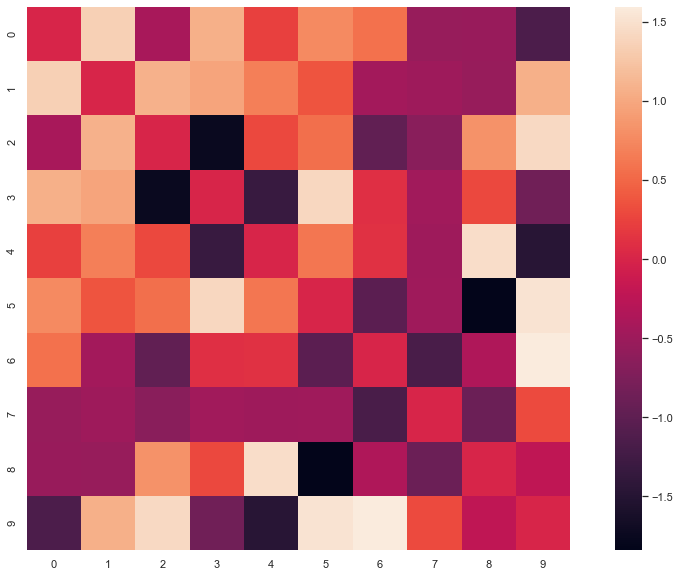

In [6]:
model.model_summary()

In [4]:
import snakeviz

In [11]:
## set current beta
beta = 1.100209
## run exact sampling over all possible configurations 
model.run_exact_sampling(beta)

running over all possible configurations: 100%|██████████| 1024/1024 [00:00<00:00, 11749.20it/s]

Running Exact Sampling | Model beta :  1.100209
saving distribution to model ...


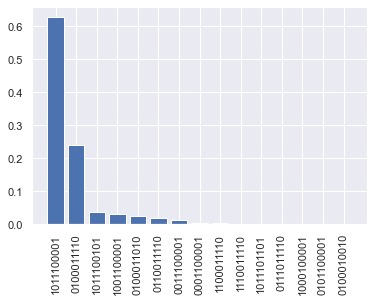

In [12]:
## get the distribution from model
bpd = model.boltzmann_pd
## plot the distribution
plot_bargraph_desc_order(bpd, label= 'Boltzmann Dist.', plot_first_few= 15)

# run classical mcmc

In [13]:
steps = 10000
mcmc_chain =classical_mcmc(
    n_hops=steps,
    model=model,
    # return_last_n_states=10,
    temperature=1/beta,
)

running MCMC steps ...:   2%|▏         | 157/10000 [00:00<00:06, 1566.15it/s]

starting with:  0001000100 with energy: 11.674


running MCMC steps ...: 100%|██████████| 10000/10000 [00:01<00:00, 6716.79it/s]


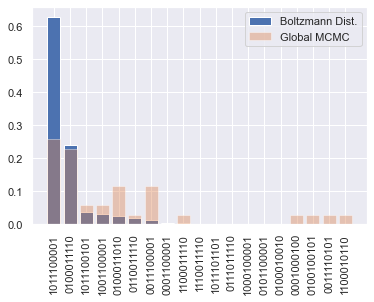

In [14]:
plot_bargraph_desc_order(bpd, label= 'Boltzmann Dist.', plot_first_few= 15)
plot_bargraph_desc_order(mcmc_chain.get_accepted_dict(), plot_first_few= -1, normalise_complete_data=True, label= 'Global MCMC', alpha=0.4)
plt.legend()
plt.show()

# Run quantum enhanced mcmc

In [15]:
steps = 10000
qamcmc_chain =quantum_enhanced_mcmc(
    n_hops=steps,
    model=model,
    temperature=1/beta,
)

runnning quantum MCMC steps . ..:   0%|          | 0/10000 [00:00<?, ?it/s]

starting with:  0001001001 with energy: 4.024000000000002
MCMCChain()


runnning quantum MCMC steps . ..: 100%|██████████| 10000/10000 [04:33<00:00, 36.50it/s]


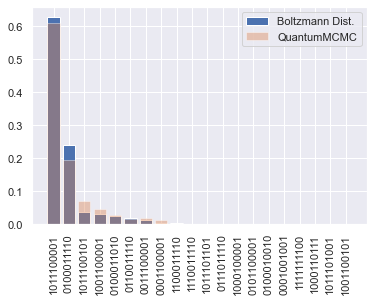

In [16]:
plot_bargraph_desc_order(bpd, label= 'Boltzmann Dist.', plot_first_few= 15)
plot_bargraph_desc_order(qamcmc_chain.get_accepted_dict(), plot_first_few= -1, normalise_complete_data=True, label= 'QuantumMCMC', alpha=0.4)
plt.legend()
plt.show()

In [ ]:
qamcmc_chain.get_accepted_dict(),mcmc_chain.get_accepted_dict()

### KL divergence

In [17]:
from tqdm import tqdm
from qumcmc.prob_dist import js_divergence, kl_divergence

In [18]:
def calculate_running_kl_divergence(actual_boltz_distn, mcmc_chain: MCMCChain, skip_steps: int = 1):
    num_nhops = len(mcmc_chain.states)
    
    list_kl_after_each_step=[]

    for step_num in tqdm(range(1, num_nhops, skip_steps)): ##pafloxy : starting at 100 instead of 0 , neglecting effect of intital states

        temp_distn_model = mcmc_chain.get_accepted_dict(normalize=True, until_index=step_num)

        kl_temp=kl_divergence(actual_boltz_distn,temp_distn_model)

        list_kl_after_each_step.append(kl_temp)


    return list_kl_after_each_step

In [20]:
skip_steps = 10

all_classical_kls = calculate_running_kl_divergence(model.boltzmann_pd, mcmc_chain, skip_steps=skip_steps)

all_quantum_kls = calculate_running_kl_divergence(model.boltzmann_pd, qamcmc_chain, skip_steps=skip_steps)

100%|██████████| 1000/1000 [00:13<00:00, 76.40it/s]


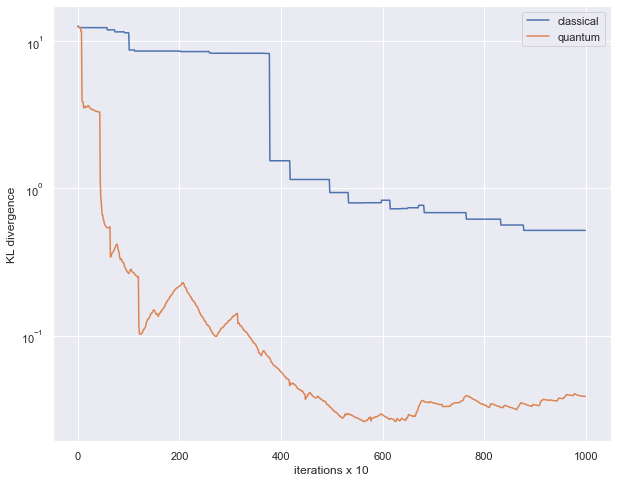

In [24]:
plt.figure(figsize=(10,8))
plt.plot(all_classical_kls, label= 'classical')
plt.plot(all_quantum_kls, label= 'quantum')
plt.xlabel(f"iterations x {skip_steps}")
plt.ylabel("KL divergence")
plt.yscale("log")
plt.legend()
plt.show()